=== ENHANCED TEXT ANALYSIS PIPELINE ===
Data loaded: 8000 feedback rows
Average feedback length: 32.4 chars

=== PREPROCESSING TEXT ===
After preprocessing: 8000 rows

=== SENTIMENT ANALYSIS ===
Sentiment distribution:
  Positive: 3945 (49.3%)
  Negative: 3221 (40.3%)
  Neutral: 834 (10.4%)

=== TOPIC MODELING ===
Document-term matrix: (8000, 48)

=== DISCOVERED TOPICS ===
Topic_1: expensive, expensive feature, feature offered, offered, feature, happy, quality, better
Topic_2: terrible, experience buy, experience, buy, terrible experience, late, late happy, delivery
Topic_3: product, better, product quality, quality, quality better, product satisfied, great, great product
Topic_4: excellent, excellent customer, customer service, customer, service, expectation, met expectation, special
Topic_5: recommend, highly recommend, highly, price happy, worth, purchase, worth price, happy purchase

Topic distribution:
  Topic 1: 816 docs (10.2%)
  Topic 2: 1579 docs (19.7%)
  Topic 3: 2400 docs (

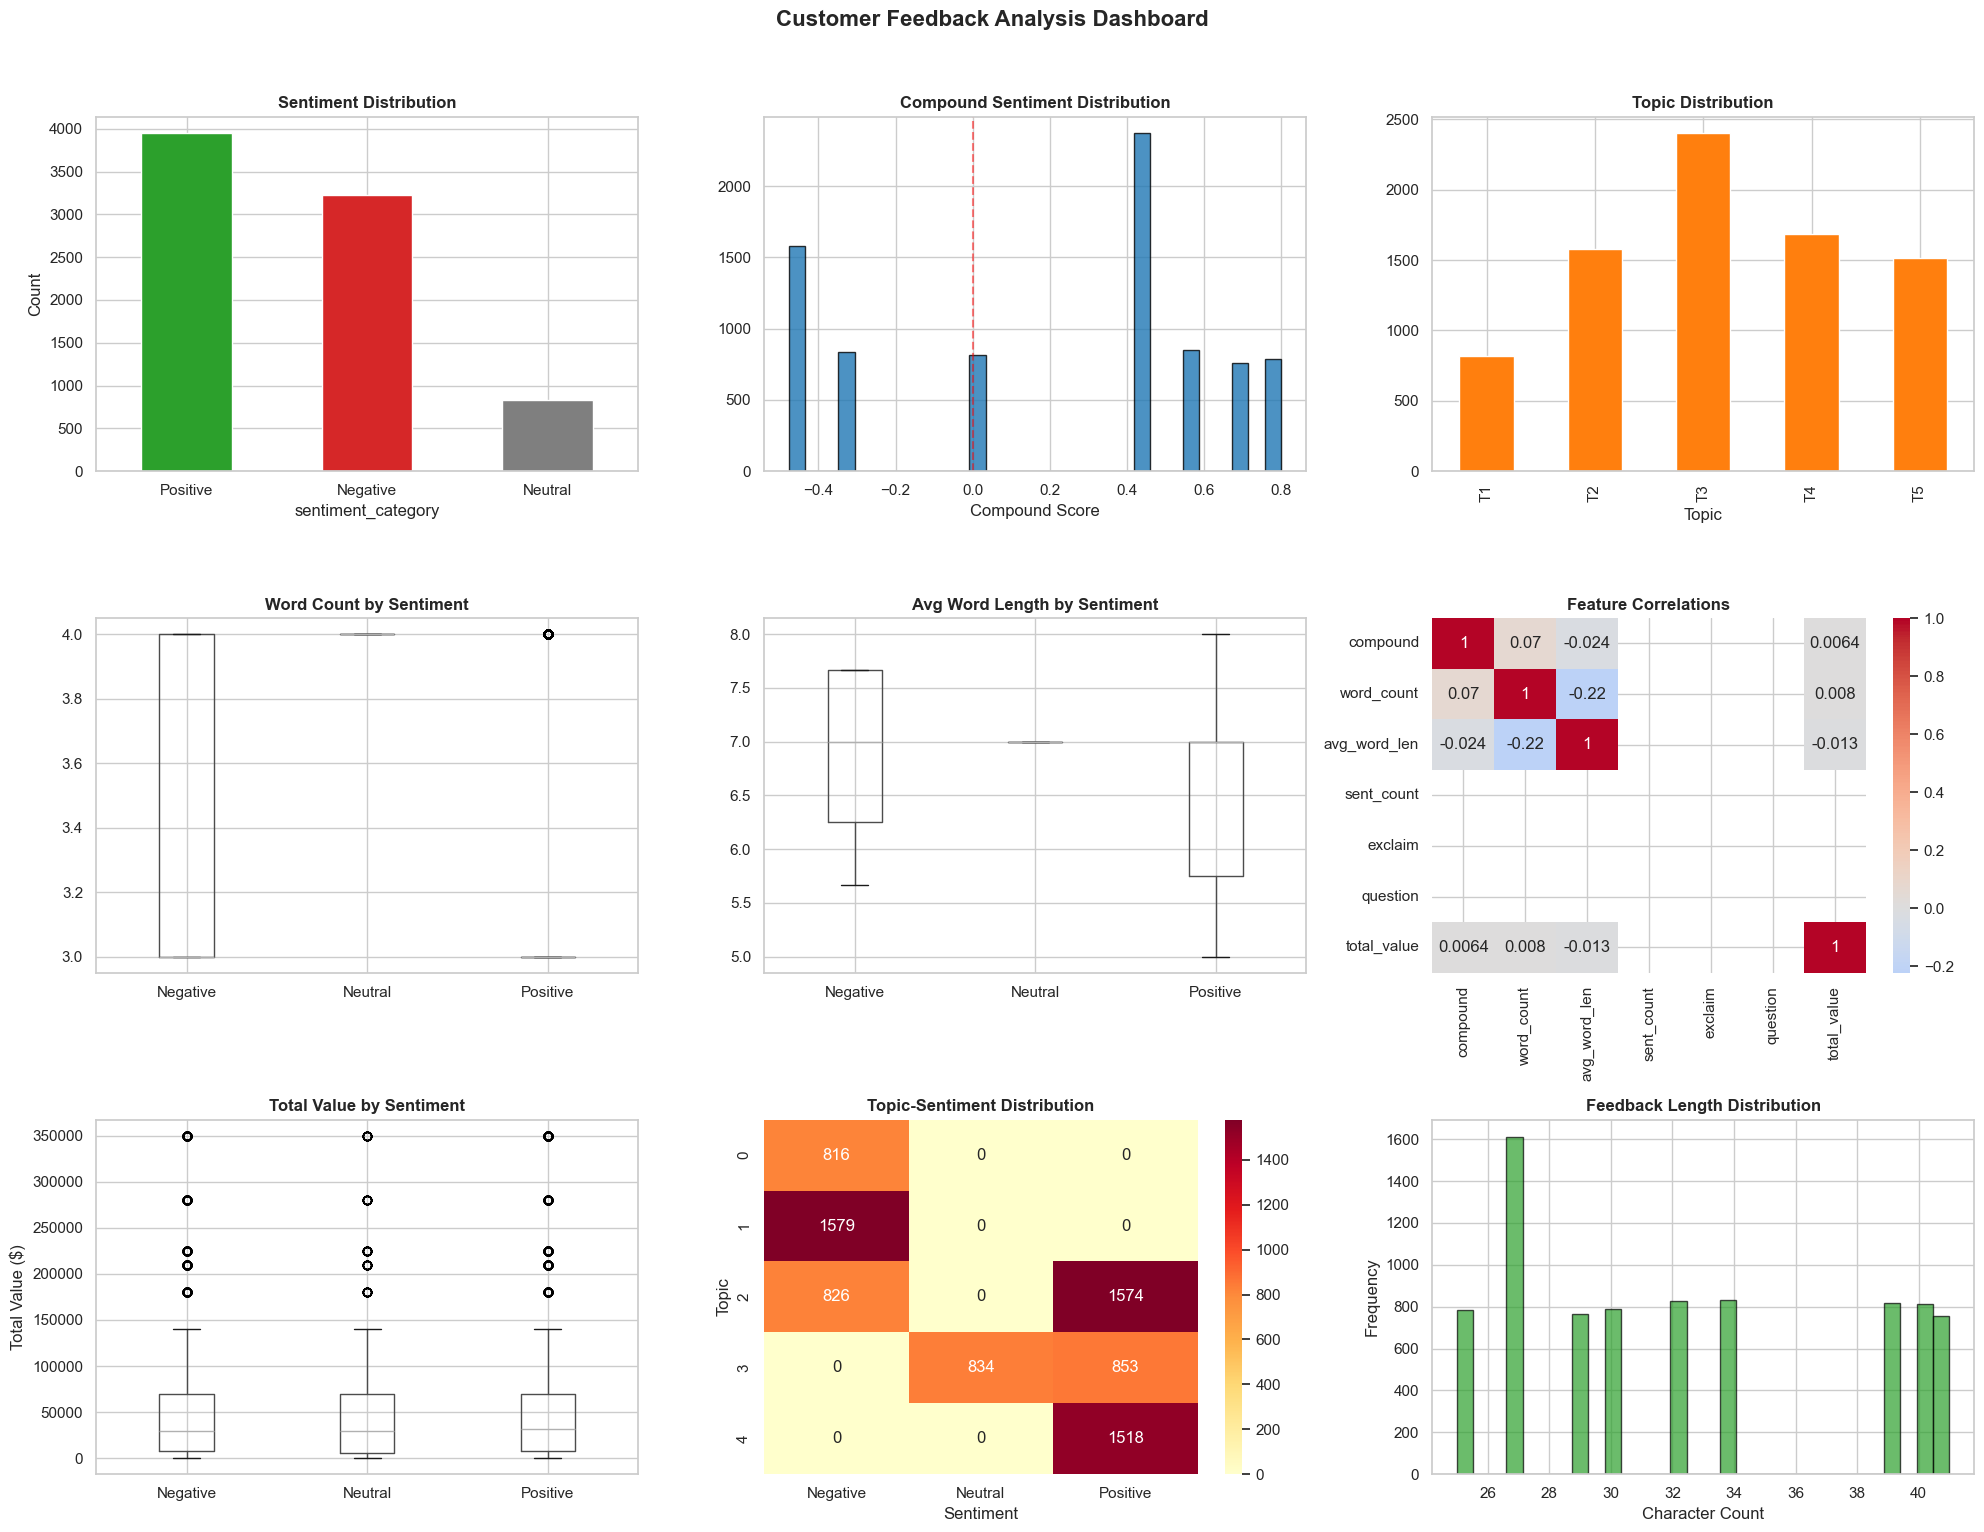


=== WORD CLOUDS ===


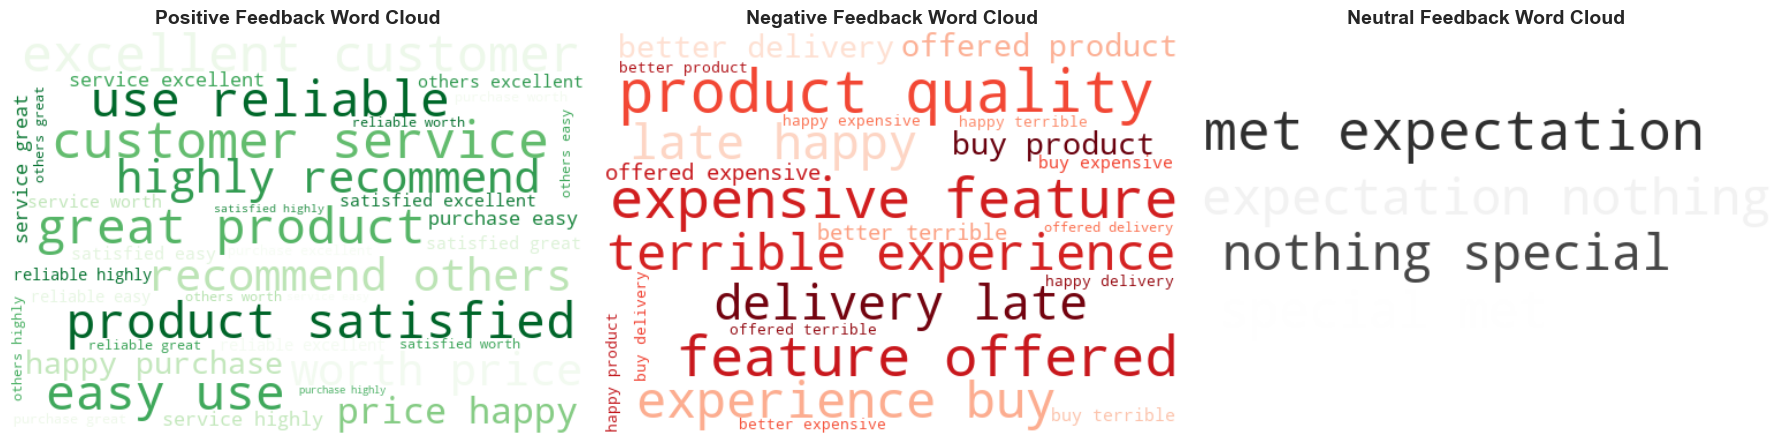


=== SAVING RESULTS ===
=== TEXT ANALYSIS COMPLETE ===
Enhanced dataset -> ../data/customer_feedback_analyzed1.csv
Topic assignments -> ../data/feedback_topics1.csv
Topic keywords -> ../data/discovered_topics1.csv
Sentiment keywords -> ../data/sentiment_keywords1.csv
Business insights -> ../data/business_insights1.csv

=== SUMMARY ===
• Feedback analyzed: 8000
• Avg compound: 0.209
• Min/Max compound: -0.477 / 0.802
• Topics discovered: 5
• Avg words per feedback: 3.3
• Total revenue analyzed: $462,413,650.00
• Revenue at risk: $118,460,000.00


In [1]:
# ===== ENHANCED TEXT ANALYSIS PIPELINE — SENTIMENT & TOPIC MODELING =====
import warnings, re
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Downloads (quiet)
for pkg in ["vader_lexicon", "stopwords", "punkt", "wordnet"]:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg, quiet=True)

# Topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Word cloud (optional)
try:
    from wordcloud import WordCloud
    HAS_WORDCLOUD = True
except ImportError:
    WordCloud = None
    HAS_WORDCLOUD = False

sns.set(style="whitegrid")
print("=== ENHANCED TEXT ANALYSIS PIPELINE ===")

# ------------------------------------------------------------------------------
# 0) Configuration & Data Loading
# ------------------------------------------------------------------------------
PATH_IN   = "../data/processed/cleaned_transactions.csv"
PATH_OUT1 = "../data/customer_feedback_analyzed1.csv"
PATH_OUT2 = "../data/feedback_topics1.csv"
PATH_OUT3 = "../data/discovered_topics1.csv"
PATH_OUT4 = "../data/sentiment_keywords1.csv"
PATH_OUT5 = "../data/business_insights1.csv"

df = pd.read_csv(PATH_IN)

# Ensure the column exists and is string
if "feedback_text" not in df.columns:
    raise ValueError("Expected a column named 'feedback_text' in the input file.")

df["feedback_text"] = df["feedback_text"].fillna("").astype(str)
df = df[df["feedback_text"].str.strip().str.len() > 0].copy()

print(f"Data loaded: {len(df)} feedback rows")
print(f"Average feedback length: {df['feedback_text'].str.len().mean():.1f} chars")

# ------------------------------------------------------------------------------
# 1) Text Preprocessing
# ------------------------------------------------------------------------------
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text: str) -> str:
        if not text:
            return ""
        t = text.lower()
        t = re.sub(r"http\S+|www\.\S+", " ", t)   
        t = re.sub(r"[^a-z\s]", " ", t)          
        t = " ".join(t.split())
        return t

    def tokenize_lemmatize(self, text: str):
        if not text:
            return []
        toks = word_tokenize(text)
        toks = [
            self.lemmatizer.lemmatize(tok)
            for tok in toks
            if tok not in self.stop_words and len(tok) > 2
        ]
        return toks

    def preprocess(self, text: str) -> str:
        cleaned = self.clean_text(text)
        toks = self.tokenize_lemmatize(cleaned)
        return " ".join(toks)

prep = TextPreprocessor()

print("\n=== PREPROCESSING TEXT ===")
df["feedback_clean"] = df["feedback_text"].apply(prep.preprocess)
df["feedback_tokens"] = df["feedback_text"].apply(lambda t: prep.tokenize_lemmatize(prep.clean_text(t)))
df["token_count"] = df["feedback_tokens"].apply(len)

# Keep only feedback with at least 3 tokens
df = df[df["token_count"] >= 3].copy()
print(f"After preprocessing: {len(df)} rows")

# ------------------------------------------------------------------------------
# 2) Enhanced Sentiment Analysis (VADER + Rule Overlay)
# ------------------------------------------------------------------------------
print("\n=== SENTIMENT ANALYSIS ===")
sia = SentimentIntensityAnalyzer()

def vader_scores(text: str):
    if not text:
        return {"neg": 0.0, "neu": 0.0, "pos": 0.0, "compound": 0.0}
    return sia.polarity_scores(text)

sent = df["feedback_text"].apply(vader_scores).apply(pd.Series)
df = pd.concat([df, sent], axis=1)

def vader_bucket(c):
    if c >= 0.05: return "Positive"
    if c <= -0.05: return "Negative"
    return "Neutral"

df["sentiment_vader"] = df["compound"].apply(vader_bucket)

# --- RULE OVERLAY for domain-specific patterns ---
NEG_PATTERNS = [
    r"\btoo\s+expensive\b", r"\bnot worth\b", r"\bcould be better\b",
    r"\bpoor (quality|service|support)\b", r"\bbad\b", r"\bterrible\b",
    r"\bwon'?t buy again\b", r"\bdisappoint", r"\bwaste\b"
]
NEU_PATTERNS = [
    r"\bmet expectations\b", r"\bnothing special\b", r"\bok\b", r"\bokay\b",
    r"\baverage\b", r"\bfine\b"
]
POS_PATTERNS = [
    r"\bexcellent\b", r"\bgreat value\b", r"\bamazing\b", r"\bhigh quality\b",
    r"\bvery satisfied\b", r"\bworth (it|the price)\b", r"\bhighly recommend\b",
    r"\bperfect\b", r"\blove\b"
]

NEG_RE = [re.compile(p, re.I) for p in NEG_PATTERNS]
NEU_RE = [re.compile(p, re.I) for p in NEU_PATTERNS]
POS_RE = [re.compile(p, re.I) for p in POS_PATTERNS]

def label_with_rules(text, default_label):
    t = text.lower()
    for r in NEG_RE:
        if r.search(t): return "Negative"
    for r in POS_RE:
        if r.search(t): return "Positive"
    for r in NEU_RE:
        if r.search(t): return "Neutral"
    return default_label

df["sentiment_category"] = df.apply(
    lambda r: label_with_rules(r["feedback_text"], r["sentiment_vader"]), axis=1
)

# Quick distribution
dist = df["sentiment_category"].value_counts()
print("Sentiment distribution:")
for k, v in dist.items():
    print(f"  {k}: {v} ({v/len(df)*100:.1f}%)")

# ------------------------------------------------------------------------------
# 3) Topic Modeling (LDA)
# ------------------------------------------------------------------------------
print("\n=== TOPIC MODELING ===")
texts_for_topics = df["feedback_clean"].tolist()

tfidf = TfidfVectorizer(
    max_features=1000,  # Good balance for topic discovery
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2),
    stop_words="english"
)
X = tfidf.fit_transform(texts_for_topics)
feat_names = tfidf.get_feature_names_out()
print(f"Document-term matrix: {X.shape}")

n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics, 
    random_state=42, 
    max_iter=20, 
    learning_method="online"
)
lda.fit(X)

def top_words(model, feature_names, top_n=10):
    topics = {}
    for i, row in enumerate(model.components_):
        best = row.argsort()[-top_n:][::-1]
        topics[f"Topic_{i+1}"] = [feature_names[j] for j in best]
    return topics

topics = top_words(lda, feat_names, 8)
print("\n=== DISCOVERED TOPICS ===")
for name, words in topics.items():
    print(f"{name}: {', '.join(words)}")

# Assign dominant topic to each doc
doc_topic = lda.transform(X)
df_topics = df.copy()
df_topics["dominant_topic"] = doc_topic.argmax(axis=1)
df_topics["topic_probability"] = doc_topic.max(axis=1)

# Topic distribution
topic_counts = df_topics["dominant_topic"].value_counts().sort_index()
print("\nTopic distribution:")
for k, v in topic_counts.items():
    print(f"  Topic {k+1}: {v} docs ({v/len(df_topics)*100:.1f}%)")

# ------------------------------------------------------------------------------
# 4) Keyword Analysis (by sentiment)
# ------------------------------------------------------------------------------
print("\n=== KEYWORD ANALYSIS ===")
def top_words_by_sentiment(frame, label, n=10):
    toks = frame[frame["sentiment_category"]==label]["feedback_tokens"]
    words = [w for ts in toks for w in ts]
    return Counter(words).most_common(n)

sentiment_keywords = {}
for s in ["Positive", "Negative", "Neutral"]:
    if (df["sentiment_category"]==s).any():
        kws = top_words_by_sentiment(df, s, 10)
        sentiment_keywords[s] = kws
        print(f"\nTop words in {s}:")
        for w, c in kws:
            print(f"  {w}: {c}")

# ------------------------------------------------------------------------------
# 5) Advanced Text Features
# ------------------------------------------------------------------------------
print("\n=== TEXT FEATURES ===")
def text_features(row):
    text = row["feedback_text"]
    tokens = row["feedback_tokens"]
    if not text:
        return pd.Series({
            "word_count": 0, "avg_word_len": 0, "sent_count": 0,
            "exclaim": 0, "question": 0, "uppercase_ratio": 0
        })
    
    wc = len(tokens)
    awl = np.mean([len(w) for w in tokens]) if tokens else 0
    sc = len(sent_tokenize(text))
    ex = text.count("!")
    qn = text.count("?")
    
    # Uppercase ratio (from first code)
    uppercase_chars = sum(1 for c in text if c.isupper())
    total_chars = len(text)
    ur = uppercase_chars / total_chars if total_chars > 0 else 0
    
    return pd.Series({
        "word_count": wc,
        "avg_word_len": awl,
        "sent_count": sc,
        "exclaim": ex,
        "question": qn,
        "uppercase_ratio": ur
    })

df_feat = df.apply(text_features, axis=1)
df_enhanced = pd.concat([df, df_feat], axis=1)

# ------------------------------------------------------------------------------
# 6) Business Insights & Analysis
# ------------------------------------------------------------------------------
print("\n=== BUSINESS INSIGHTS ===")

# Basic business metrics by sentiment
if "total_value" in df_enhanced.columns:
    sentiment_business = df_enhanced.groupby("sentiment_category").agg({
        "total_value": ["mean", "sum", "count"],
        "price": "mean",
        "quantity": "mean",
        "compound": "mean"
    }).round(2)
    
    print("Sentiment vs Business Metrics:")
    print(sentiment_business)
    
    # High-value customer analysis (from first code)
    high_value_threshold = df_enhanced["total_value"].quantile(0.8)
    high_value_customers = df_enhanced[df_enhanced["total_value"] > high_value_threshold]
    
    print(f"\nHigh-value customer sentiment (top 20%):")
    print(f"  Threshold: ${high_value_threshold:.2f}")
    high_value_sentiment = high_value_customers["sentiment_category"].value_counts(normalize=True)
    for sentiment, ratio in high_value_sentiment.items():
        print(f"  {sentiment}: {ratio*100:.1f}%")
    
    # Revenue at risk (negative sentiment high-value customers)
    revenue_at_risk = high_value_customers[
        high_value_customers["sentiment_category"] == "Negative"
    ]["total_value"].sum()
    print(f"\nRevenue at risk (high-value negative sentiment): ${revenue_at_risk:,.2f}")

# Topic-Sentiment Cross Analysis
topic_sent = pd.crosstab(df_topics["dominant_topic"], df["sentiment_category"])
print("\nTopic × Sentiment:")
print(topic_sent)

# Advanced insights
if "age" in df_enhanced.columns:
    age_sentiment = df_enhanced.groupby("sentiment_category")["age"].agg(["mean", "std"]).round(1)
    print("\nAge distribution by sentiment:")
    print(age_sentiment)

# ------------------------------------------------------------------------------
# 7) Visualizations
# ------------------------------------------------------------------------------
print("\n=== VISUALIZATIONS ===")
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# A) Sentiment Distribution
colors = {"Positive": "#2ca02c", "Negative": "#d62728", "Neutral": "#7f7f7f"}
dist.plot(kind="bar", ax=axes[0,0], color=[colors.get(x, "#1f77b4") for x in dist.index])
axes[0,0].set_title("Sentiment Distribution", fontsize=12, fontweight='bold')
axes[0,0].set_ylabel("Count")
axes[0,0].tick_params(axis="x", rotation=0)

# B) Sentiment Score Histogram
axes[0,1].hist(df_enhanced["compound"], bins=30, alpha=0.8, color="#1f77b4", edgecolor='black')
axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0,1].set_title("Compound Sentiment Distribution", fontsize=12, fontweight='bold')
axes[0,1].set_xlabel("Compound Score")

# C) Topic Distribution
topic_counts.index = [f"T{k+1}" for k in topic_counts.index]
topic_counts.plot(kind="bar", ax=axes[0,2], color="#ff7f0e")
axes[0,2].set_title("Topic Distribution", fontsize=12, fontweight='bold')
axes[0,2].set_xlabel("Topic")

# D) Word Count by Sentiment
df_enhanced.boxplot(column="word_count", by="sentiment_category", ax=axes[1,0])
axes[1,0].set_title("Word Count by Sentiment", fontsize=12, fontweight='bold')
axes[1,0].set_xlabel("")

# E) Average Word Length by Sentiment
df_enhanced.boxplot(column="avg_word_len", by="sentiment_category", ax=axes[1,1])
axes[1,1].set_title("Avg Word Length by Sentiment", fontsize=12, fontweight='bold')
axes[1,1].set_xlabel("")

# F) Correlation Heatmap
corr_cols = ["compound", "word_count", "avg_word_len", "sent_count", "exclaim", "question"]
if "total_value" in df_enhanced.columns:
    corr_cols.append("total_value")
sns.heatmap(df_enhanced[corr_cols].corr(), annot=True, cmap="coolwarm", center=0, ax=axes[1,2])
axes[1,2].set_title("Feature Correlations", fontsize=12, fontweight='bold')

# G) Sentiment vs Total Value (if available)
if "total_value" in df_enhanced.columns:
    df_enhanced.boxplot(column="total_value", by="sentiment_category", ax=axes[2,0])
    axes[2,0].set_title("Total Value by Sentiment", fontsize=12, fontweight='bold')
    axes[2,0].set_xlabel("")
    axes[2,0].set_ylabel("Total Value ($)")
else:
    axes[2,0].text(0.5, 0.5, "No 'total_value' column", ha='center', va='center')
    axes[2,0].set_title("Total Value by Sentiment (N/A)")

# H) Topic-Sentiment Heatmap
sns.heatmap(topic_sent, annot=True, fmt="d", cmap="YlOrRd", ax=axes[2,1])
axes[2,1].set_title("Topic-Sentiment Distribution", fontsize=12, fontweight='bold')
axes[2,1].set_xlabel("Sentiment")
axes[2,1].set_ylabel("Topic")

# I) Text Length Distribution
axes[2,2].hist(df_enhanced["feedback_text"].str.len(), bins=30, alpha=0.7, color="#2ca02c", edgecolor='black')
axes[2,2].set_title("Feedback Length Distribution", fontsize=12, fontweight='bold')
axes[2,2].set_xlabel("Character Count")
axes[2,2].set_ylabel("Frequency")

plt.suptitle("Customer Feedback Analysis Dashboard", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Word Clouds with sentiment-based colors
if HAS_WORDCLOUD:
    print("\n=== WORD CLOUDS ===")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Color schemes for each sentiment
    color_maps = {
        "Positive": "Greens",
        "Negative": "Reds", 
        "Neutral": "Greys"
    }
    
    for i, s in enumerate(["Positive", "Negative", "Neutral"]):
        text = " ".join(df[df["sentiment_category"]==s]["feedback_clean"])
        if not text.strip():
            axes[i].set_title(f"No {s} texts")
            axes[i].axis("off")
            continue
        
        wc = WordCloud(
            width=500, 
            height=350, 
            background_color="white",
            colormap=color_maps[s],
            max_words=100
        ).generate(text)
        
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f"{s} Feedback Word Cloud", fontsize=14, fontweight='bold')
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 8) Save Results
# ------------------------------------------------------------------------------
print("\n=== SAVING RESULTS ===")

# 1. Enhanced dataset with all features
df_enhanced.to_csv(PATH_OUT1, index=False)

# 2. Topic assignments
to_save = df_topics.copy()
if "customer_id" in df.columns:
    to_save["customer_id"] = df["customer_id"].values
cols_to_save = ["feedback_text", "sentiment_category", "compound", "dominant_topic", "topic_probability"]
if "customer_id" in to_save.columns:
    cols_to_save.insert(0, "customer_id")
to_save[cols_to_save].to_csv(PATH_OUT2, index=False)

# 3. Discovered topic keywords
topics_df = pd.DataFrame(
    [(k, ", ".join(v)) for k, v in topics.items()],
    columns=["Topic", "Keywords"]
)
topics_df.to_csv(PATH_OUT3, index=False)

# 4. Sentiment keywords
sk_rows = []
for s, words in (sentiment_keywords or {}).items():
    for w, c in words:
        sk_rows.append({"sentiment": s, "word": w, "count": c})
pd.DataFrame(sk_rows).to_csv(PATH_OUT4, index=False)

# 5. Business insights summary
insights = []

# Add sentiment distribution
for sentiment, count in dist.items():
    insights.append({
        "metric": f"sentiment_{sentiment.lower()}_count",
        "value": count,
        "percentage": f"{count/len(df)*100:.1f}%"
    })

# Add business metrics if available
if "total_value" in df_enhanced.columns:
    insights.append({
        "metric": "high_value_threshold",
        "value": f"${high_value_threshold:.2f}",
        "percentage": "80th percentile"
    })
    insights.append({
        "metric": "revenue_at_risk",
        "value": f"${revenue_at_risk:,.2f}",
        "percentage": f"{revenue_at_risk/df_enhanced['total_value'].sum()*100:.1f}%"
    })

# Add text statistics
insights.extend([
    {"metric": "avg_compound_score", "value": f"{df_enhanced['compound'].mean():.3f}", "percentage": ""},
    {"metric": "avg_words_per_feedback", "value": f"{df_enhanced['word_count'].mean():.1f}", "percentage": ""},
    {"metric": "total_feedbacks", "value": len(df_enhanced), "percentage": "100%"}
])

pd.DataFrame(insights).to_csv(PATH_OUT5, index=False)

print("=== TEXT ANALYSIS COMPLETE ===")
print(f"Enhanced dataset -> {PATH_OUT1}")
print(f"Topic assignments -> {PATH_OUT2}")
print(f"Topic keywords -> {PATH_OUT3}")
print(f"Sentiment keywords -> {PATH_OUT4}")
print(f"Business insights -> {PATH_OUT5}")

# Final summary
print("\n=== SUMMARY ===")
print(f"• Feedback analyzed: {len(df_enhanced)}")
print(f"• Avg compound: {df_enhanced['compound'].mean():.3f}")
print(f"• Min/Max compound: {df_enhanced['compound'].min():.3f} / {df_enhanced['compound'].max():.3f}")
print(f"• Topics discovered: {len(topics)}")
print(f"• Avg words per feedback: {df_enhanced['word_count'].mean():.1f}")

if "total_value" in df_enhanced.columns:
    print(f"• Total revenue analyzed: ${df_enhanced['total_value'].sum():,.2f}")
    print(f"• Revenue at risk: ${revenue_at_risk:,.2f}")

=== TEXT ANALYSIS PIPELINE ===
Data loaded: 8000 feedback rows
Average feedback length: 32.4 chars

=== PREPROCESSING TEXT ===
After preprocessing: 8000 rows

=== SENTIMENT ANALYSIS ===
Sentiment distribution:
  Positive: 3945 (49.3%)
  Negative: 3221 (40.3%)
  Neutral: 834 (10.4%)

=== TOPIC MODELING ===
Document-term matrix: (8000, 48)

=== DISCOVERED TOPICS ===
Topic_1: expensive, expensive feature, feature offered, offered, feature, happy, quality, better
Topic_2: terrible, experience buy, experience, buy, terrible experience, late, late happy, delivery
Topic_3: product, better, product quality, quality, quality better, product satisfied, great, great product
Topic_4: excellent, excellent customer, customer service, customer, service, expectation, met expectation, special
Topic_5: recommend, highly recommend, highly, price happy, worth, purchase, worth price, happy purchase

Topic distribution:
  Topic 1: 816 docs (10.2%)
  Topic 2: 1579 docs (19.7%)
  Topic 3: 2400 docs (30.0%)
  

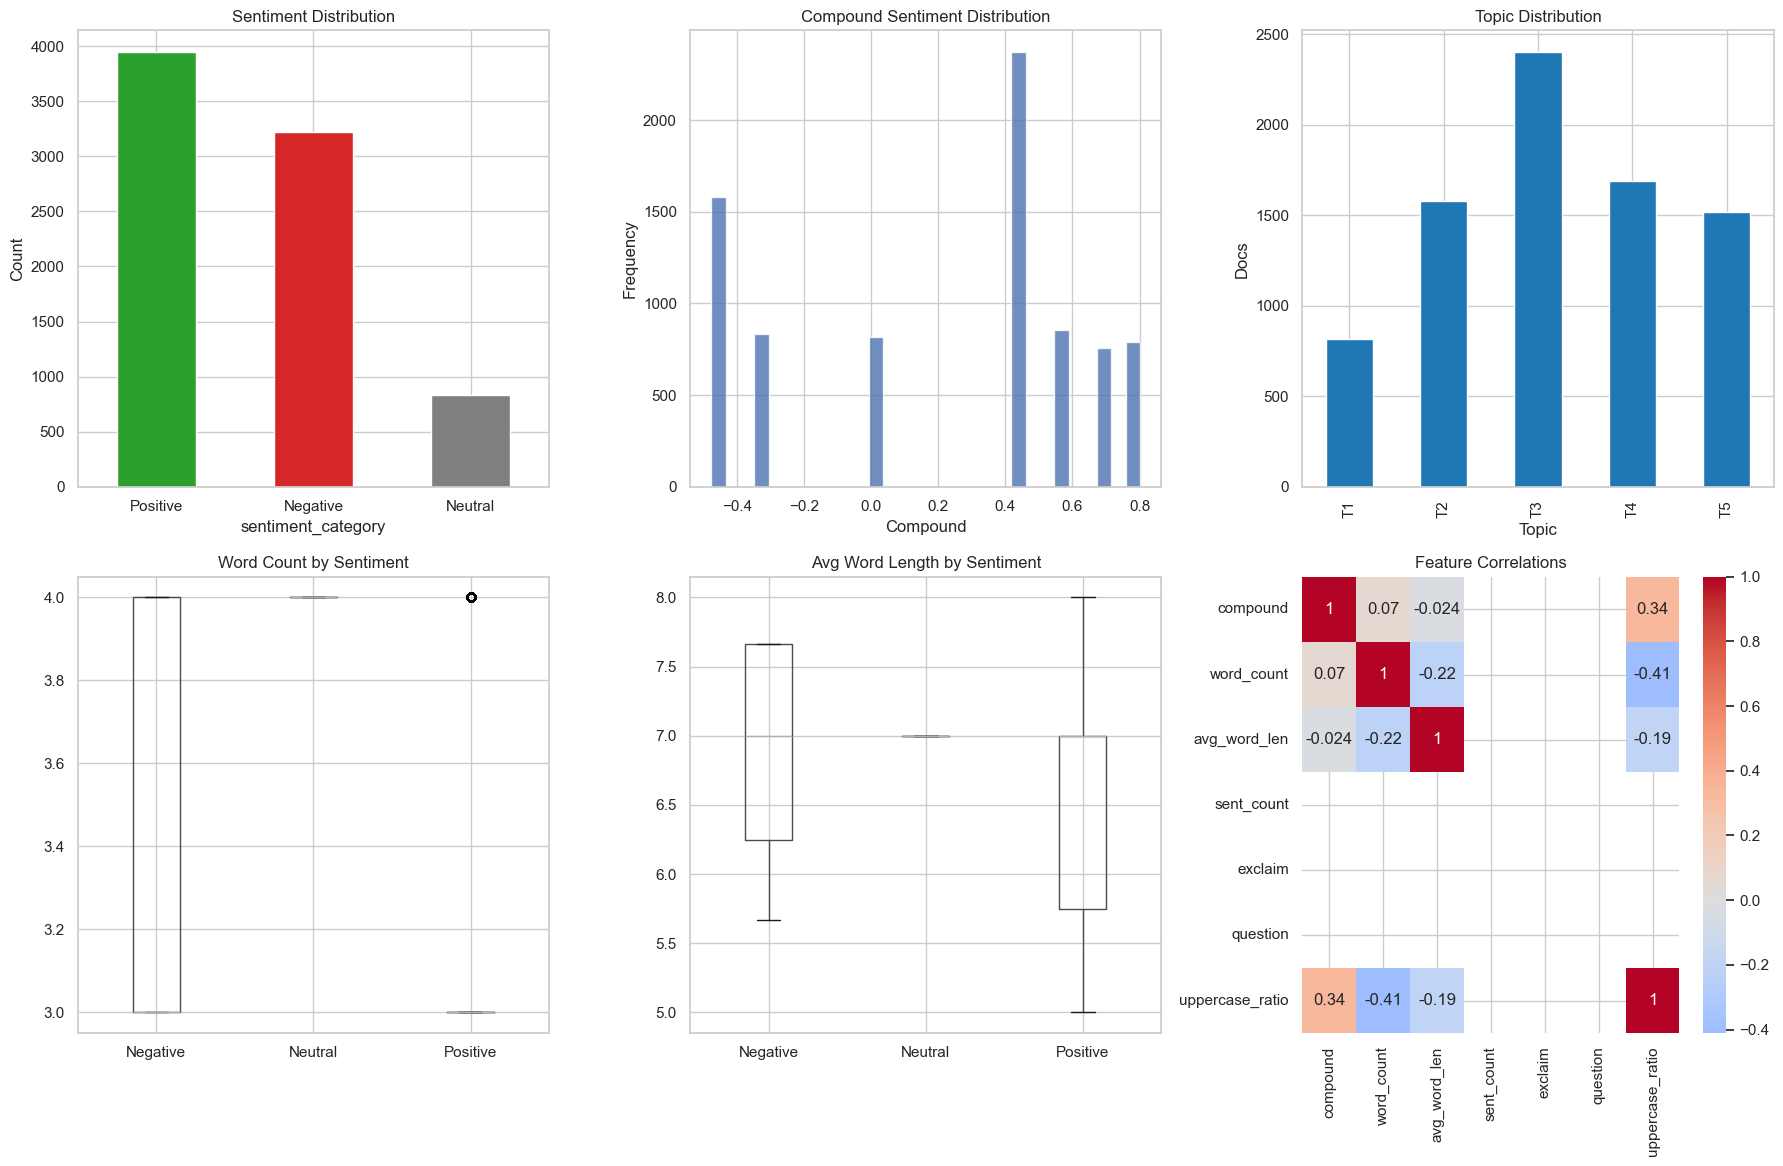


=== WORD CLOUDS ===


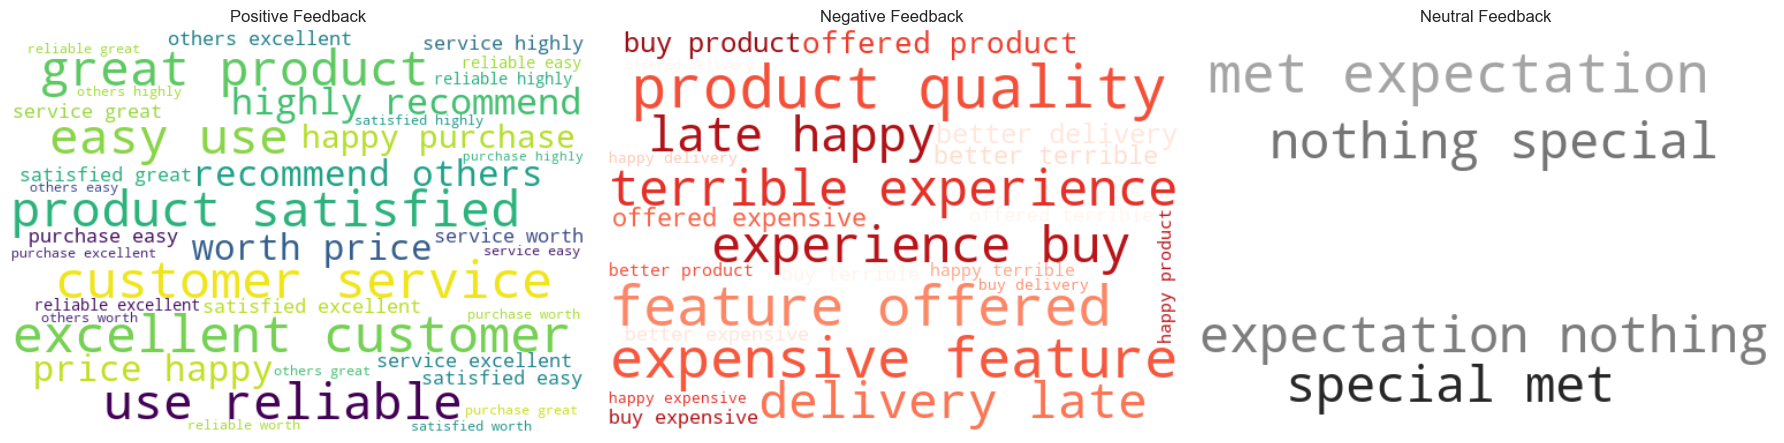


=== BUSINESS INSIGHTS ===
Total Value by Sentiment:
                    total_value_mean  total_value_sum     n
sentiment_category                                         
Negative                    58406.50        188127350  3221
Neutral                     54555.94         45499650   834
Positive                    57994.08        228786650  3945

Topic × Sentiment:
sentiment_category  Negative  Neutral  Positive
dominant_topic                                 
0                        816        0         0
1                       1579        0         0
2                        826        0      1574
3                          0      834       853
4                          0        0      1518

=== SAVING RESULTS ===
=== TEXT ANALYSIS COMPLETE ===
Enhanced dataset -> ../data/text/customer_feedback_analyzed.csv
Topic assignments -> ../data/text/feedback_topics.csv
Topic keywords    -> ../data/text/discovered_topics.csv
Sentiment keywords-> ../data/text/sentiment_keywords.csv

=== 

In [2]:
# ===== TEXT ANALYSIS PIPELINE — SENTIMENT & TOPIC MODELING (merged best-of-both) =====
import warnings, re, sys
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ----------------------------- NLTK setup -----------------------------
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure NLTK resources (robust but quiet)
_NLTK_RES = {
    "vader_lexicon": "sentiment/vader_lexicon",
    "stopwords": "corpora/stopwords",
    "punkt": "tokenizers/punkt",
    "wordnet": "corpora/wordnet",
}
for pkg, path in _NLTK_RES.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(pkg, quiet=True)

# ----------------------------- Topic modeling -----------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ----------------------------- Word cloud (optional) -----------------------------
try:
    from wordcloud import WordCloud
except Exception:
    WordCloud = None

sns.set(style="whitegrid")
print("=== TEXT ANALYSIS PIPELINE ===")

# ------------------------------------------------------------------------------
# 0) Paths & load
# ------------------------------------------------------------------------------
PATH_IN   = "../data/processed/cleaned_transactions.csv"
PATH_OUT1 = "../data/text/customer_feedback_analyzed.csv"
PATH_OUT2 = "../data/text/feedback_topics.csv"
PATH_OUT3 = "../data/text/discovered_topics.csv"
PATH_OUT4 = "../data/text/sentiment_keywords.csv"

df = pd.read_csv(PATH_IN)

if "feedback_text" not in df.columns:
    raise ValueError("Expected a column named 'feedback_text' in the input file.")

df["feedback_text"] = df["feedback_text"].fillna("").astype(str)
df = df[df["feedback_text"].str.strip().str.len() > 0].copy()

print(f"Data loaded: {len(df)} feedback rows")
print(f"Average feedback length: {df['feedback_text'].str.len().mean():.1f} chars")

# ------------------------------------------------------------------------------
# 1) Text preprocessing
# ------------------------------------------------------------------------------
class TextPreprocessor:
    def __init__(self):
        self.stop_words  = set(stopwords.words("english"))
        self.lemmatizer  = WordNetLemmatizer()

    def clean_text(self, text: str) -> str:
        if not text:
            return ""
        t = text.lower()
        t = re.sub(r"http\S+|www\.\S+", " ", t)       # remove URLs
        t = re.sub(r"[^a-z\s]", " ", t)               # keep letters only
        t = " ".join(t.split())
        return t

    def tokenize_lemmatize(self, text: str):
        if not text:
            return []
        toks = word_tokenize(text)
        toks = [
            self.lemmatizer.lemmatize(tok)
            for tok in toks
            if tok not in self.stop_words and len(tok) > 2
        ]
        return toks

    def preprocess(self, text: str) -> str:
        cleaned = self.clean_text(text)
        toks    = self.tokenize_lemmatize(cleaned)
        return " ".join(toks)

prep = TextPreprocessor()

print("\n=== PREPROCESSING TEXT ===")
df["feedback_clean"]  = df["feedback_text"].apply(prep.preprocess)
df["feedback_tokens"] = df["feedback_text"].apply(lambda t: prep.tokenize_lemmatize(prep.clean_text(t)))
df["token_count"]     = df["feedback_tokens"].apply(len)

# Keep only feedback with at least 3 tokens (tweak if needed)
df = df[df["token_count"] >= 3].copy()
print(f"After preprocessing: {len(df)} rows")

# ------------------------------------------------------------------------------
# 2) Sentiment (VADER) + rules overlay
# ------------------------------------------------------------------------------
print("\n=== SENTIMENT ANALYSIS ===")
sia = SentimentIntensityAnalyzer()

def vader_scores(text: str):
    if not text:
        return {"neg":0.0, "neu":0.0, "pos":0.0, "compound":0.0}
    return sia.polarity_scores(text)

sent = df["feedback_text"].apply(vader_scores).apply(pd.Series)
df = pd.concat([df, sent], axis=1)

def vader_bucket(c):
    if c >=  0.05: return "Positive"
    if c <= -0.05: return "Negative"
    return "Neutral"

df["sentiment_vader"] = df["compound"].apply(vader_bucket)

# Phrase-level rules (override obvious misses)
NEG_PATTERNS = [
    r"\btoo\s+expensive\b", r"\bnot worth\b", r"\bcould be better\b",
    r"\bpoor (quality|service|support)\b", r"\bbad\b", r"\bterrible\b",
    r"\bwon'?t buy again\b"
]
NEU_PATTERNS = [
    r"\bmet expectations\b", r"\bnothing special\b", r"\bok\b", r"\bokay\b",
    r"\baverage\b"
]
POS_PATTERNS = [
    r"\bexcellent\b", r"\bgreat value\b", r"\bamazing\b", r"\bhigh quality\b",
    r"\bvery satisfied\b", r"\bworth (it|the price)\b"
]
NEG_RE = [re.compile(p, re.I) for p in NEG_PATTERNS]
NEU_RE = [re.compile(p, re.I) for p in NEU_PATTERNS]
POS_RE = [re.compile(p, re.I) for p in POS_PATTERNS]

def label_with_rules(text, default_label):
    t = text.lower()
    for r in NEG_RE:
        if r.search(t): return "Negative"
    for r in POS_RE:
        if r.search(t): return "Positive"
    for r in NEU_RE:
        if r.search(t): return "Neutral"
    return default_label

df["sentiment_category"] = df.apply(
    lambda r: label_with_rules(r["feedback_text"], r["sentiment_vader"]), axis=1
)

# Quick distribution
dist = df["sentiment_category"].value_counts()
print("Sentiment distribution:")
for k,v in dist.items():
    print(f"  {k}: {v} ({v/len(df)*100:.1f}%)")

# ------------------------------------------------------------------------------
# 3) Topic modeling (LDA on TF-IDF)
# ------------------------------------------------------------------------------
print("\n=== TOPIC MODELING ===")
texts_for_topics = df["feedback_clean"].tolist()

tfidf = TfidfVectorizer(
    max_features=1000,      # richer vocab than first script (tweakable)
    max_df=0.8,
    min_df=2,
    ngram_range=(1,2),
    stop_words="english"
)
X = tfidf.fit_transform(texts_for_topics)
feat_names = tfidf.get_feature_names_out()
print(f"Document-term matrix: {X.shape}")

n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics, random_state=42, max_iter=20, learning_method="online"
)
lda.fit(X)

def top_words(model, feature_names, top_n=8):
    topics = {}
    for i, row in enumerate(model.components_):
        best = row.argsort()[-top_n:][::-1]
        topics[f"Topic_{i+1}"] = [feature_names[j] for j in best]
    return topics

topics = top_words(lda, feat_names, 8)
print("\n=== DISCOVERED TOPICS ===")
for name, words in topics.items():
    print(f"{name}: {', '.join(words)}")

# Assign dominant topic to each doc
doc_topic = lda.transform(X)
df_topics = df.copy()
df_topics["dominant_topic"]    = doc_topic.argmax(axis=1)
df_topics["topic_probability"] = doc_topic.max(axis=1)

# Topic distribution
topic_counts = df_topics["dominant_topic"].value_counts().sort_index()
print("\nTopic distribution:")
for k, v in topic_counts.items():
    print(f"  Topic {k+1}: {v} docs ({v/len(df_topics)*100:.1f}%)")

# ------------------------------------------------------------------------------
# 4) Keyword analysis (by sentiment)
# ------------------------------------------------------------------------------
print("\n=== KEYWORD ANALYSIS ===")
def top_words_by_sentiment(frame, label, n=10):
    toks = frame[frame["sentiment_category"]==label]["feedback_tokens"]
    words = [w for ts in toks for w in ts]
    return Counter(words).most_common(n)

sentiment_keywords = {}
for s in ["Positive","Negative","Neutral"]:
    if (df["sentiment_category"]==s).any():
        kws = top_words_by_sentiment(df, s, 10)
        sentiment_keywords[s] = kws
        print(f"\nTop words in {s}:")
        for w,c in kws:
            print(f"  {w}: {c}")

# ------------------------------------------------------------------------------
# 5) Text features (includes uppercase_ratio from First code)
# ------------------------------------------------------------------------------
print("\n=== TEXT FEATURES ===")
def text_features(row):
    text   = row["feedback_text"]
    tokens = row["feedback_tokens"]
    if not text:
        return pd.Series({
            "word_count":0, "avg_word_len":0, "sent_count":0,
            "exclaim":0, "question":0, "uppercase_ratio":0.0
        })
    wc  = len(tokens)
    awl = np.mean([len(w) for w in tokens]) if tokens else 0
    sc  = len(sent_tokenize(text))
    ex  = text.count("!")
    qn  = text.count("?")
    total_chars = len(text)
    upper_chars = sum(1 for ch in text if ch.isupper())
    up_ratio    = (upper_chars / total_chars) if total_chars > 0 else 0.0
    return pd.Series({
        "word_count": wc,
        "avg_word_len": awl,
        "sent_count": sc,
        "exclaim": ex,
        "question": qn,
        "uppercase_ratio": up_ratio
    })

df_feat = df.apply(text_features, axis=1)
df_enhanced = pd.concat([df, df_feat], axis=1)

# ------------------------------------------------------------------------------
# 6) Visualizations
# ------------------------------------------------------------------------------
print("\n=== VISUALIZATIONS ===")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# A) Sentiment counts
dist.plot(kind="bar", ax=axes[0,0], color=["#2ca02c","#d62728","#7f7f7f"])
axes[0,0].set_title("Sentiment Distribution")
axes[0,0].set_ylabel("Count"); axes[0,0].tick_params(axis="x", rotation=0)

# B) Compound sentiment histogram
axes[0,1].hist(df_enhanced["compound"], bins=30, alpha=0.8)
axes[0,1].set_title("Compound Sentiment Distribution")
axes[0,1].set_xlabel("Compound"); axes[0,1].set_ylabel("Frequency")

# C) Topic distribution
topic_counts.index = [f"T{k+1}" for k in topic_counts.index]
topic_counts.plot(kind="bar", ax=axes[0,2], color="#1f77b4")
axes[0,2].set_title("Topic Distribution")
axes[0,2].set_xlabel("Topic"); axes[0,2].set_ylabel("Docs")

# D) Word count by sentiment
df_enhanced.boxplot(column="word_count", by="sentiment_category", ax=axes[1,0])
axes[1,0].set_title("Word Count by Sentiment"); axes[1,0].set_xlabel("")

# E) Avg word length by sentiment
df_enhanced.boxplot(column="avg_word_len", by="sentiment_category", ax=axes[1,1])
axes[1,1].set_title("Avg Word Length by Sentiment"); axes[1,1].set_xlabel("")

# F) Correlation heatmap (only on available columns)
corr_cols = [c for c in ["compound","word_count","avg_word_len","sent_count","exclaim","question","uppercase_ratio"]
             if c in df_enhanced.columns]
if len(corr_cols) >= 2:
    sns.heatmap(df_enhanced[corr_cols].corr(), annot=True, cmap="coolwarm", center=0, ax=axes[1,2])
    axes[1,2].set_title("Feature Correlations")
else:
    axes[1,2].axis("off")
    axes[1,2].set_title("Correlation: insufficient columns")

plt.suptitle("")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 7) Word clouds (optional) with per-sentiment colormaps (from First code style)
# ------------------------------------------------------------------------------
if WordCloud is not None:
    print("\n=== WORD CLOUDS ===")
    cmap_map = {
        "Positive": "viridis",
        "Negative": "Reds",
        "Neutral":  "gray"
    }
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, s in enumerate(["Positive","Negative","Neutral"]):
        text = " ".join(df[df["sentiment_category"]==s]["feedback_clean"])
        if not text.strip():
            axes[i].set_title(f"No {s} texts"); axes[i].axis("off"); continue
        wc = WordCloud(width=500, height=350, background_color="white",
                       colormap=cmap_map.get(s, "viridis")).generate(text)
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f"{s} Feedback"); axes[i].axis("off")
    plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------
# 8) Business-style aggregates (guarded)
# ------------------------------------------------------------------------------
print("\n=== BUSINESS INSIGHTS ===")
if "total_value" in df_enhanced.columns:
    grp = (
        df_enhanced.groupby("sentiment_category")
        .agg(total_value_mean=("total_value","mean"),
             total_value_sum=("total_value","sum"),
             n=("feedback_text","count"))
        .round(2)
    )
    print("Total Value by Sentiment:")
    print(grp)

# Topic × Sentiment crosstab
topic_sent = pd.crosstab(df_topics["dominant_topic"], df["sentiment_category"])
print("\nTopic × Sentiment:")
print(topic_sent)

# ------------------------------------------------------------------------------
# 9) Save results
# ------------------------------------------------------------------------------
print("\n=== SAVING RESULTS ===")
df_enhanced.to_csv(PATH_OUT1, index=False)

# topics file (document-level)
to_save = df_topics.copy()
if "customer_id" in df.columns:
    to_save["customer_id"] = df["customer_id"].values
to_save[["feedback_text","sentiment_category","compound","dominant_topic","topic_probability"]].to_csv(
    PATH_OUT2, index=False
)

# discovered topic keywords
topics_df = pd.DataFrame(
    [(k, ", ".join(v)) for k,v in topics.items()],
    columns=["Topic","Keywords"]
)
topics_df.to_csv(PATH_OUT3, index=False)

# sentiment keywords
sk_rows = []
for s, words in (sentiment_keywords or {}).items():
    for w,c in words:
        sk_rows.append({"sentiment": s, "word": w, "count": c})
pd.DataFrame(sk_rows).to_csv(PATH_OUT4, index=False)

print("=== TEXT ANALYSIS COMPLETE ===")
print(f"Enhanced dataset -> {PATH_OUT1}")
print(f"Topic assignments -> {PATH_OUT2}")
print(f"Topic keywords    -> {PATH_OUT3}")
print(f"Sentiment keywords-> {PATH_OUT4}")

# Final summary
print("\n=== SUMMARY ===")
print(f"• Feedback analyzed: {len(df_enhanced)}")
print(f"• Avg compound: {df_enhanced['compound'].mean():.3f}")
print(f"• Min/Max compound: {df_enhanced['compound'].min():.3f} / {df_enhanced['compound'].max():.3f}")
print(f"• Topics discovered: {len(topics)}")
print(f"• Avg words per feedback: {df_enhanced['word_count'].mean():.1f}")
